## Machine Learning

In the following steps we will perform the following:

- Prepare the dataset
- Split in train and test
- Transform/Encode the features kand labels
- Test a wide range of ML models (Tree-based, Probabilistic and so on).
- Compare the accuracry of all models.
- Choose our winning model and tune hyperparameters to target a higher accuracy.
- Make a more profound evaluation of the result with a confusion matrix and different measures.
- Identify the most important features to predict the rating.

In [ ]:
# import dependancies
from pathlib import Path
from sqlalchemy import create_engine
import pandas as pd

from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base

from sqlalchemy.orm import Session

from sqlalchemy import func

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for color palette
import warnings
from pathlib import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import tensorflow as tf
import numpy as np
from scipy import stats
# Import the kerastuner library
import keras_tuner as kt
import matplotlib.ticker as mtick


# Ignore all warnings
warnings.filterwarnings("ignore")



In [52]:
# starting a sql engine 

# Replace these values with your database credentials
db_host = "127.0.0.1"
db_port = "5432"
db_name = "machinelearningDB"
db_user = "postgres"
db_password = "postgres"

# Create a PostgreSQL database connection using SQLAlchemy
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

# Create a Session class to interact with the database
Session = sessionmaker(bind=engine)

# Establish a session to execute SQL queries
try:
    session = Session()

    # Example: Execute a simple SQL query
    result = session.execute("SELECT version();")
    version = result.scalar()
    print("Connected to the database. PostgreSQL version:", version)


except Exception as e:
    print("Error while connecting to PostgreSQL:", e)



Connected to the database. PostgreSQL version: PostgreSQL 12.15, compiled by Visual C++ build 1914, 64-bit


In [53]:
# reading in sql table and saving as dataframe
df = pd.read_sql_query(f"SELECT * FROM stock_data", con=engine)
df.head()

,industry,wr1,wr2,wr3,wr4,vol1,vol2,vol3,vol4,pe_ratio,...,profit_margin,free_cash_margin,volatility,cpi,interest_rate,unemployment_rate,sma,rsi,ema,label
0,Consumer Discretionary,-0.019375,0.042774,-0.009555,-0.007692,6230100.0,6996900.0,6377700.0,7026700.0,30.01,...,14.40,13.74,0.025251,241.428,0.40,5.0,56.240000,8.149406,56.300000,0
1,Utilities,0.025644,0.011924,-0.006826,0.031470,175800.0,195300.0,233900.0,221400.0,17.58,...,11.15,1.49,0.013118,238.132,0.36,5.0,73.803333,87.796610,73.714583,0
2,Real Estate,0.057182,-0.004482,-0.040843,0.036994,1298900.0,3493600.0,571100.0,832500.0,62.13,...,12.97,29.98,0.019104,237.838,0.13,5.0,23.196667,88.260870,23.240833,0
3,Industrials,-0.044857,0.062964,0.055392,-0.058078,1071300.0,880100.0,1080400.0,994800.0,6.68,...,27.43,-18.14,0.023650,305.691,5.08,3.5,235.736667,11.037986,235.240833,0
4,Consumer Staples,0.022806,-0.021995,0.021842,-0.028000,6563300.0,6745100.0,9474700.0,10172500.0,10.28,...,4.55,10.21,0.019597,259.101,0.10,10.2,63.633333,72.448980,63.837083,1


In [54]:
# getting df info to ensure no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   industry                  1914 non-null   object 
 1   wr1                       1914 non-null   float64
 2   wr2                       1914 non-null   float64
 3   wr3                       1914 non-null   float64
 4   wr4                       1914 non-null   float64
 5   vol1                      1914 non-null   float64
 6   vol2                      1914 non-null   float64
 7   vol3                      1914 non-null   float64
 8   vol4                      1914 non-null   float64
 9   pe_ratio                  1914 non-null   float64
 10  debt_to_equity            1914 non-null   float64
 11  quick_ratio               1914 non-null   float64
 12  total_shareholder_return  1914 non-null   float64
 13  profit_margin             1914 non-null   float64
 14  free_cas

## Preprocessing the data

- Separate the label and features 
- Encode numerical columns, in this case, the industry column
- Split the data into training and testing data
- Scaling the data based on the training data


In [55]:
# Separate the data into labels and features

# Separate the y variable, the labels
y = df["label"]

# Separate the X variable, the features
X = df.drop(columns="label")

In [56]:
# Review the y variable Series
y[:5]

0    0
1    0
2    0
3    0
4    1
Name: label, dtype: int64

In [57]:
# Review the X variable DataFrame
X[:5]

,industry,wr1,wr2,wr3,wr4,vol1,vol2,vol3,vol4,pe_ratio,...,total_shareholder_return,profit_margin,free_cash_margin,volatility,cpi,interest_rate,unemployment_rate,sma,rsi,ema
0,Consumer Discretionary,-0.019375,0.042774,-0.009555,-0.007692,6230100.0,6996900.0,6377700.0,7026700.0,30.01,...,3.80,14.40,13.74,0.025251,241.428,0.40,5.0,56.240000,8.149406,56.300000
1,Utilities,0.025644,0.011924,-0.006826,0.031470,175800.0,195300.0,233900.0,221400.0,17.58,...,2.64,11.15,1.49,0.013118,238.132,0.36,5.0,73.803333,87.796610,73.714583
2,Real Estate,0.057182,-0.004482,-0.040843,0.036994,1298900.0,3493600.0,571100.0,832500.0,62.13,...,4.97,12.97,29.98,0.019104,237.838,0.13,5.0,23.196667,88.260870,23.240833
3,Industrials,-0.044857,0.062964,0.055392,-0.058078,1071300.0,880100.0,1080400.0,994800.0,6.68,...,0.66,27.43,-18.14,0.023650,305.691,5.08,3.5,235.736667,11.037986,235.240833
4,Consumer Staples,0.022806,-0.021995,0.021842,-0.028000,6563300.0,6745100.0,9474700.0,10172500.0,10.28,...,2.18,4.55,10.21,0.019597,259.101,0.10,10.2,63.633333,72.448980,63.837083


In [58]:
# One-hot encode the 'industry' column
X = pd.get_dummies(X, columns=['industry'])

X.head()

,wr1,wr2,wr3,wr4,vol1,vol2,vol3,vol4,pe_ratio,debt_to_equity,...,industry_Consumer Staples,industry_Energy,industry_Finance,industry_Health Care,industry_Industrials,industry_Miscellaneous,industry_Real Estate,industry_Technology,industry_Telecommunications,industry_Utilities
0,-0.019375,0.042774,-0.009555,-0.007692,6230100.0,6996900.0,6377700.0,7026700.0,30.01,0.63,...,False,False,False,False,False,False,False,False,False,False
1,0.025644,0.011924,-0.006826,0.031470,175800.0,195300.0,233900.0,221400.0,17.58,0.85,...,False,False,False,False,False,False,False,False,False,True
2,0.057182,-0.004482,-0.040843,0.036994,1298900.0,3493600.0,571100.0,832500.0,62.13,0.60,...,False,False,False,False,False,False,True,False,False,False
3,-0.044857,0.062964,0.055392,-0.058078,1071300.0,880100.0,1080400.0,994800.0,6.68,0.36,...,False,False,False,False,True,False,False,False,False,False
4,0.022806,-0.021995,0.021842,-0.028000,6563300.0,6745100.0,9474700.0,10172500.0,10.28,1.35,...,True,False,False,False,False,False,False,False,False,False


In [59]:
# reviewing new featureset
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   wr1                              1914 non-null   float64
 1   wr2                              1914 non-null   float64
 2   wr3                              1914 non-null   float64
 3   wr4                              1914 non-null   float64
 4   vol1                             1914 non-null   float64
 5   vol2                             1914 non-null   float64
 6   vol3                             1914 non-null   float64
 7   vol4                             1914 non-null   float64
 8   pe_ratio                         1914 non-null   float64
 9   debt_to_equity                   1914 non-null   float64
 10  quick_ratio                      1914 non-null   float64
 11  total_shareholder_return         1914 non-null   float64
 12  profit_margin       

In [60]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


## List of Machine Learning Models Used:

### 1. Random Forest (RF) 
### 2. XG Boost (XGB)
### 3. Tensor Flow (TF)
### 4. Logistic Regression (LR)
### 5. Linear Discriminant Analysis (LDT)
### 6. Neural Network (MLP)
### 7. K-Nearest Neighbors Algorithm (KNN)
### 8. Decision Tree Algorithm (DT) 
### 9. Bagging Decision Tree (BGT)
### 10. Gradient Boosting Classifier (GBT)
### 11. Support Vector Machine (SVM)
### 12. Naive Bayes Classifier (NB) 

### 1. Predicting the label using Random Forest

In [61]:
RF_model = RandomForestClassifier(random_state=1234)
RF_model.fit(X_train_scaled,y_train)

RF_training_predictions = RF_model.predict(X_train_scaled)
y_pred_RF = RF_model.predict(X_test_scaled)

Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)

print("RF Accuracy:",Accuracy_RF)

RF Accuracy: 0.5031315240083507


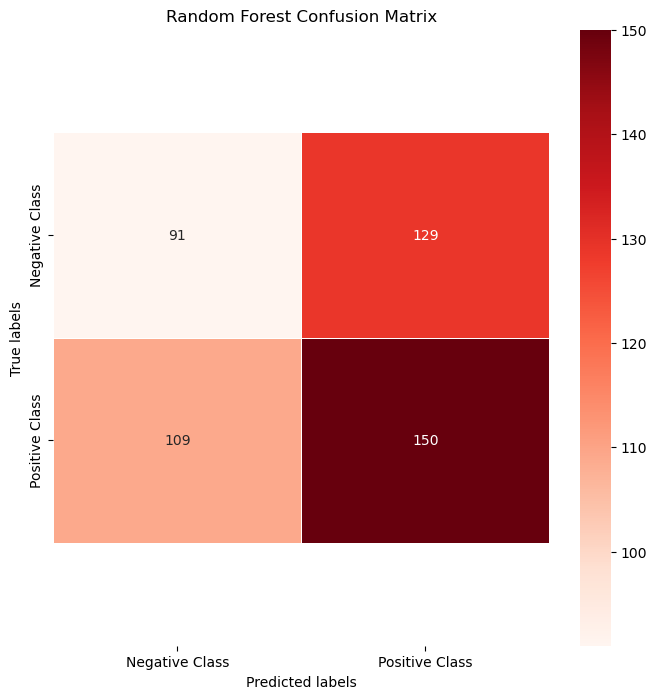

In [62]:
# Generate the confusion matrix
cm_RF = confusion_matrix(y_test, y_pred_RF)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_RF, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forest Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()

In [63]:
# Print the classification report for the model

# Create and save the training classification report
training_report_RF = classification_report(y_train, RF_training_predictions)
testing_report_RF = classification_report(y_test, y_pred_RF)

# Print the training classification report
print("Random Forest Classification Report: Training Data")
print("---------------------------------------------------")
print(training_report_RF)
print("")
print("Random Forest Classification Report: Testing Data")
print("---------------------------------------------------")
print(testing_report_RF)

Random Forest Classification Report: Training Data
---------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       682
           1       1.00      1.00      1.00       753

    accuracy                           1.00      1435
   macro avg       1.00      1.00      1.00      1435
weighted avg       1.00      1.00      1.00      1435


Random Forest Classification Report: Testing Data
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.41      0.43       220
           1       0.54      0.58      0.56       259

    accuracy                           0.50       479
   macro avg       0.50      0.50      0.50       479
weighted avg       0.50      0.50      0.50       479



#### From the matrix above it appears we have an over-fitting problem
______________________________________________________________________________________________________________________________

### 2. Predicting the label using XGBoost

In [64]:
# Create a binary XGBoost model
XGB_model = xgb.XGBClassifier(objective='binary:logistic')

# Train the model
XGB_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_XGB = XGB_model.predict(X_test_scaled)

# Calculate accuracy
accuracy_XGB = metrics.accuracy_score(y_test, y_pred_XGB)
print("XGB Accuracy (Binary Classification):", accuracy_XGB)

XGB Accuracy (Binary Classification): 0.5615866388308977


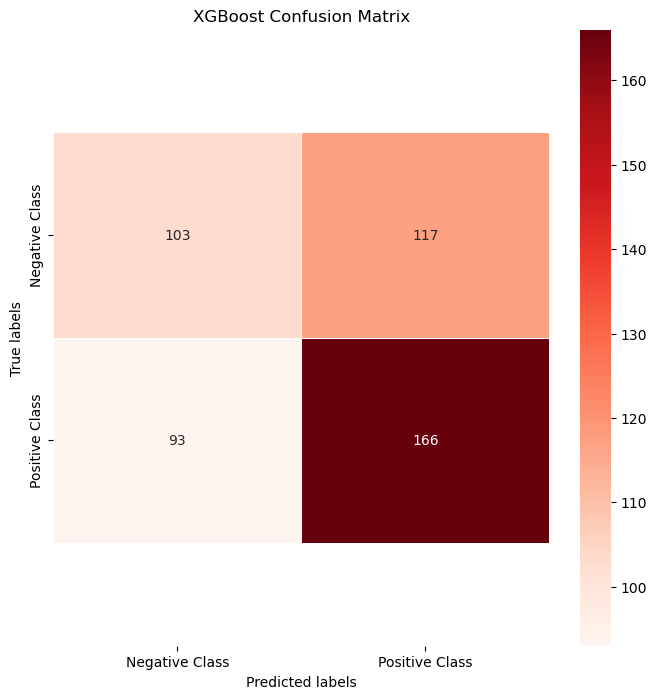

In [65]:
# Generate the confusion matrix
cm_XGB = confusion_matrix(y_test, y_pred_XGB)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_XGB, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('XGBoost Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()


In [66]:
# Print the classification report for the model

# Create and save the training classification report
XGB_training_predictions = XGB_model.predict(X_train_scaled)

training_report = classification_report(y_train, XGB_training_predictions)
testing_report = classification_report(y_test, y_pred_XGB)

# Print the training classification report
print("XGBoost Classification Report: Training Data")
print("---------------------------------------------")
print(training_report_RF)
print("")
print("XGBoost Classification Report: Testing Data")
print("--------------------------------------------")
print(testing_report_RF)

XGBoost Classification Report: Training Data
---------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       682
           1       1.00      1.00      1.00       753

    accuracy                           1.00      1435
   macro avg       1.00      1.00      1.00      1435
weighted avg       1.00      1.00      1.00      1435


XGBoost Classification Report: Testing Data
--------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.41      0.43       220
           1       0.54      0.58      0.56       259

    accuracy                           0.50       479
   macro avg       0.50      0.50      0.50       479
weighted avg       0.50      0.50      0.50       479



#### Once again, we appear to have an over-fitting problem
_______________________________________________________________________________________________________________________________

### 3. Predicting the label with Tensor Flow

In [67]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 20

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 80)                2800      
                                                                 
 dense_13 (Dense)            (None, 30)                2430      
                                                                 
 dense_14 (Dense)            (None, 20)                620       
                                                                 
 dense_15 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5871 (22.93 KB)
Trainable params: 5871 (22.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
           
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)
           
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
45/45 [==============================] - 3s 5ms/step - loss: 0.6983 - accuracy: 0.5164
Epoch 2/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.5686
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 0.6653 - accuracy: 0.6056
Epoch 4/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6547 - accuracy: 0.6084
Epoch 5/100
45/45 [==============================] - 0s 6ms/step - loss: 0.6471 - accuracy: 0.6195
Epoch 6/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6350 - accuracy: 0.6418
Epoch 7/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6258 - accuracy: 0.6564
Epoch 8/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6126 - accuracy: 0.6655
Epoch 9/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6037 - accuracy: 0.6669
Epoch 10/100
45/45 [==============================] - 0s 6ms/step - loss: 0.5912 - accuracy: 0.6787
Epoch 11/

45/45 [==============================] - 0s 4ms/step - loss: 0.0937 - accuracy: 0.9770
Epoch 84/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0899 - accuracy: 0.9749
Epoch 85/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0820 - accuracy: 0.9840
Epoch 86/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0803 - accuracy: 0.9826
Epoch 87/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0763 - accuracy: 0.9847
Epoch 88/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0733 - accuracy: 0.9840
Epoch 89/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0761 - accuracy: 0.9826
Epoch 90/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0720 - accuracy: 0.9833
Epoch 91/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0712 - accuracy: 0.9819
Epoch 92/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0652 - accuracy: 0.9854
Epoch 93/100


In [69]:
Accuracy_TF1 = model_accuracy

In [70]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  100
hidden_nodes_layer2 = 60
hidden_nodes_layer3 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh")
)
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()
     

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               3500      
                                                                 
 dense_17 (Dense)            (None, 60)                6060      
                                                                 
 dense_18 (Dense)            (None, 30)                1830      
                                                                 
 dense_19 (Dense)            (None, 1)                 31        
                                                                 
Total params: 11421 (44.61 KB)
Trainable params: 11421 (44.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
           
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)
           
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
45/45 [==============================] - 3s 5ms/step - loss: 0.7107 - accuracy: 0.5185
Epoch 2/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5261
Epoch 3/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6856 - accuracy: 0.5429
Epoch 4/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6776 - accuracy: 0.5540
Epoch 5/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6734 - accuracy: 0.5686
Epoch 6/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6695 - accuracy: 0.5742
Epoch 7/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6651 - accuracy: 0.5805
Epoch 8/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6598 - accuracy: 0.5895
Epoch 9/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6556 - accuracy: 0.5972
Epoch 10/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6488 - accuracy: 0.6146
Epoch 11/

45/45 [==============================] - 0s 5ms/step - loss: 0.0941 - accuracy: 0.9777
Epoch 84/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0896 - accuracy: 0.9798
Epoch 85/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0850 - accuracy: 0.9805
Epoch 86/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0837 - accuracy: 0.9819
Epoch 87/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0771 - accuracy: 0.9861
Epoch 88/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0709 - accuracy: 0.9895
Epoch 89/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0689 - accuracy: 0.9833
Epoch 90/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0678 - accuracy: 0.9861
Epoch 91/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0643 - accuracy: 0.9909
Epoch 92/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0600 - accuracy: 0.9923
Epoch 93/100


In [72]:
Accuracy_TF2 = model_accuracy

### 4. Predicting the label with Logistic Regression

In [73]:
LR_model = LogisticRegression(random_state=1234 , solver='lbfgs')
LR_model = LR_model.fit(X_train_scaled, y_train)
LR_training_predictions = LR_model.predict(X_train_scaled)
y_pred_LR = LR_model.predict(X_test_scaled)
Accuracy_LR = metrics.accuracy_score(y_test, y_pred_LR)

print("LR Accuracy:",Accuracy_LR)

LR Accuracy: 0.5323590814196242


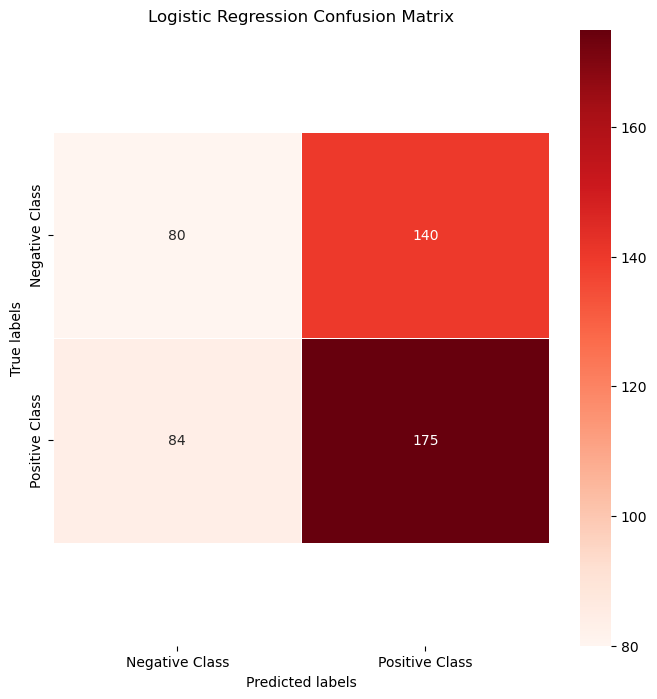

In [74]:
# Generate the confusion matrix
cm_LR = confusion_matrix(y_test, y_pred_LR)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_LR, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()

In [75]:
# Print the classification report for the model

# Create and save the training classification report
training_report_LR = classification_report(y_train, RF_training_predictions)
testing_report_LR = classification_report(y_test, y_pred_LR)

# Print the training classification report
print("Logistic Regression Classification Report: Training Data")
print("----------------------------------------------------------")
print(training_report_LR)
print("")
print("Logistic Regression Classification Report: Testing Data")
print("---------------------------------------------------------")
print(testing_report_LR)

Logistic Regression Classification Report: Training Data
----------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       682
           1       1.00      1.00      1.00       753

    accuracy                           1.00      1435
   macro avg       1.00      1.00      1.00      1435
weighted avg       1.00      1.00      1.00      1435


Logistic Regression Classification Report: Testing Data
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.49      0.36      0.42       220
           1       0.56      0.68      0.61       259

    accuracy                           0.53       479
   macro avg       0.52      0.52      0.51       479
weighted avg       0.52      0.53      0.52       479



### 5. Predicting the label with Linear Discrimant Analysis

In [76]:
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train_scaled,y_train)
LDA_training_predictions = LDA_model.predict(X_train_scaled) 
y_pred_LDA = LDA_model.predict(X_test_scaled)
Accuracy_LDA = metrics.accuracy_score(y_test, y_pred_LDA)

print("LDA Accuracy:",Accuracy_LDA)

LDA Accuracy: 0.5302713987473904


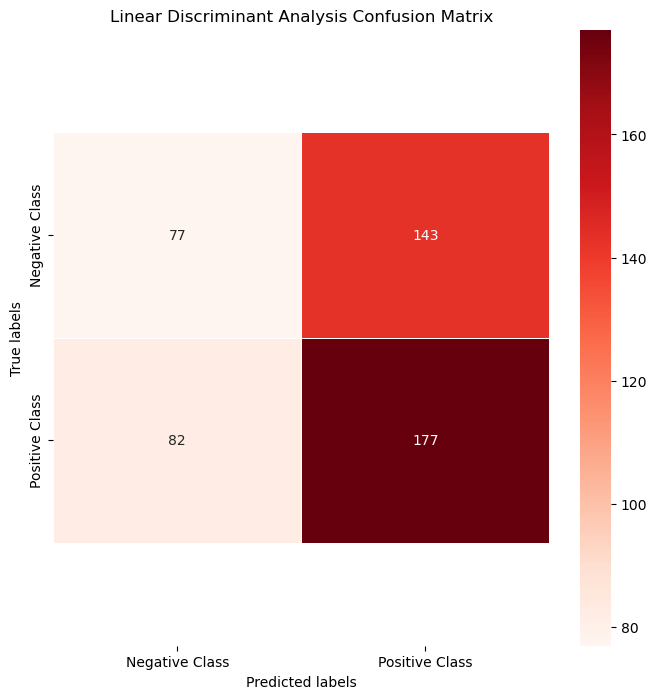

In [77]:
# Generate the confusion matrix
cm_LDA = confusion_matrix(y_test, y_pred_LDA)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_LDA, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Linear Discriminant Analysis Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()

In [78]:
# Print the classification report for the model

 # Create and save the training classification report
training_report_LDA = classification_report(y_train, LDA_training_predictions)
testing_report_LDA = classification_report(y_test, y_pred_LDA)

# Print the training classification report
print("Linear Discriminant Analysis Classification Report: Training Data")
print("-------------------------------------------------------------------")
print(training_report_LDA)
print("")
print("Linear Discriminant Analysis Classification Report: Testing Data")
print("-------------------------------------------------------------------")
print(testing_report_LDA)

Linear Discriminant Analysis Classification Report: Training Data
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.38      0.44       682
           1       0.55      0.69      0.61       753

    accuracy                           0.54      1435
   macro avg       0.54      0.54      0.53      1435
weighted avg       0.54      0.54      0.53      1435


Linear Discriminant Analysis Classification Report: Testing Data
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.35      0.41       220
           1       0.55      0.68      0.61       259

    accuracy                           0.53       479
   macro avg       0.52      0.52      0.51       479
weighted avg       0.52      0.53      0.52       479



### 6. Predicting the label with Neural Networks

In [79]:
# Simple hyperparamter selection to act as a starting point

MLP_accuracy={}
for i in range(1, 100, 5):
    MLP_model = MLPClassifier(hidden_layer_sizes=(i,i,i), activation='relu', solver='adam', max_iter=1500)
    MLP_model.fit(X_train_scaled, y_train)
    MLP_training_predictions = MLP_model.predict(X_train_scaled)
    y_pred_MLP = MLP_model.predict(X_test_scaled)
    Accuracy_MLP = metrics.accuracy_score(y_test, y_pred_MLP)
    MLP_accuracy[i]=Accuracy_MLP
    


NameError: name 'accuracy_dict' is not defined

In [83]:
optimal_layers = max(MLP_accuracy, key=lambda k: MLP_accuracy[k])

print(f"Optimal no. of hidden layers is {optimal_layers}")


Optimal no. of hidden layers is 16


In [85]:
MLP_model = MLPClassifier(hidden_layer_sizes=(16,16,16), activation='relu', solver='adam', max_iter=1500)
MLP_model.fit(X_train_scaled, y_train)
MLP_training_predictions = MLP_model.predict(X_train_scaled)
y_pred_MLP = MLP_model.predict(X_test_scaled)
Accuracy_MLP = metrics.accuracy_score(y_test, y_pred_MLP)

print("MLP Accuracy:",Accuracy_MLP)

MLP Accuracy: 0.5177453027139874


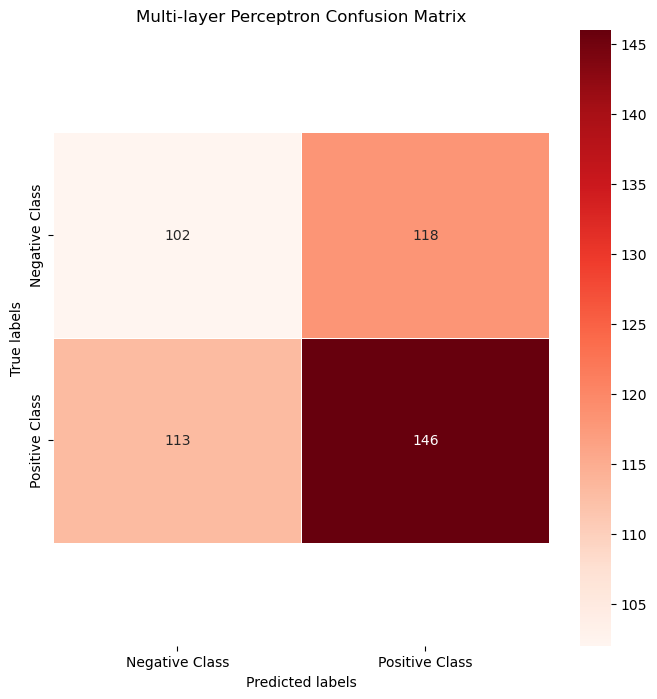

In [86]:
# Generate the confusion matrix
cm_MLP = confusion_matrix(y_test, y_pred_MLP)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_MLP, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Multi-layer Perceptron Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()

In [89]:
# Print the classification report for the model

# Create and save the training classification report
training_report_MLP = classification_report(y_train, MLP_training_predictions)
testing_report_MLP = classification_report(y_test, y_pred_MLP)

# Print the training classification report
print("Multi-layer Perceptron Classification Report: Training Data")
print("-------------------------------------------------------------")
print(training_report_MLP)
print("")
print("Multi-layer Perceptron Classification Report: Testing Data")
print("--------------------------------------------------------------")
print(testing_report_MLP)

Multi-layer Perceptron Classification Report: Training Data
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       682
           1       0.93      0.94      0.93       753

    accuracy                           0.93      1435
   macro avg       0.93      0.93      0.93      1435
weighted avg       0.93      0.93      0.93      1435


Multi-layer Perceptron Classification Report: Testing Data
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.46      0.47       220
           1       0.55      0.56      0.56       259

    accuracy                           0.52       479
   macro avg       0.51      0.51      0.51       479
weighted avg       0.52      0.52      0.52       479



### 7. Predicting the label with K-Nearest Neighbors Algorithm (KNN) 

In [90]:
# Simple hyperparamter selection to act as a starting point

KNN_accuracy={}
for i in range(1, 100, 5):
    KNN_model = KNeighborsClassifier(n_neighbors=i)

    # Train the model
    KNN_model.fit(X_train_scaled, y_train)
    KNN_training_predictions = KNN_model.predict(X_train_scaled)

    # Create predictions
    y_pred_KNN = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    KNN_accuracy[i] = accuracy
    
optimal_n = max(KNN_accuracy, key=lambda k: KNN_accuracy[i])

print(f"Optimal no. of hidden layers is {optimal_n}")

Optimal no. of hidden layers is 1


In [131]:
KNN_model = KNeighborsClassifier(n_neighbors=1)

# Train the model
KNN_model.fit(X_train_scaled, y_train)
KNN_training_predictions = KNN_model.predict(X_train_scaled)

# Create predictions
y_pred_KNN = model.predict(X_test_scaled)
Accuracy_KNN = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.5532359081419624


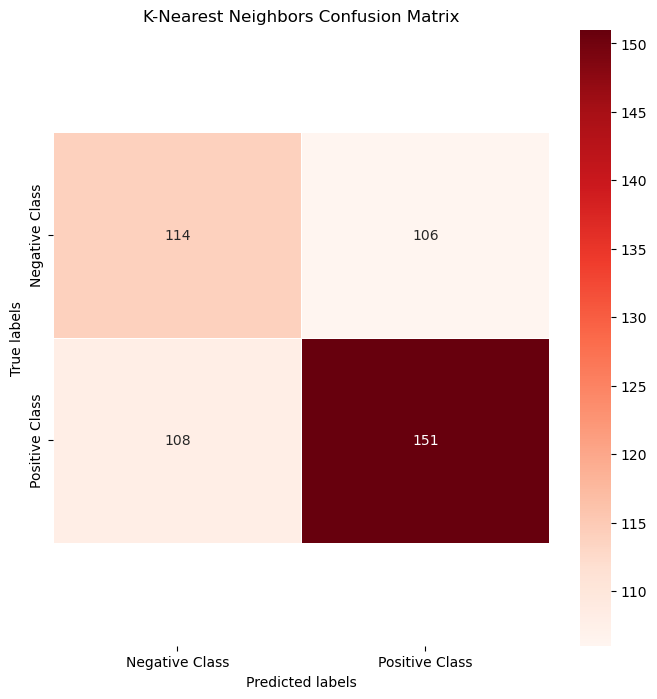

In [92]:
# Generate the confusion matrix
cm_KNN = confusion_matrix(y_test, y_pred_KNN)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_KNN, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('K-Nearest Neighbors Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()

In [93]:
# Print the classification report for the model

# Create and save the training classification report
training_report_KNN = classification_report(y_train, KNN_training_predictions)
testing_report_KNN = classification_report(y_test, y_pred_KNN)

# Print the training classification report
print("K-Nearest Neighbors Classification Report: Training Data")
print("----------------------------------------------------------")
print(training_report_KNN)
print("")
print("K-Nearest Neighbors Classification Report: Testing Data")
print("----------------------------------------------------------")
print(testing_report_KNN)

K-Nearest Neighbors Classification Report: Training Data
----------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       682
           1       1.00      1.00      1.00       753

    accuracy                           1.00      1435
   macro avg       1.00      1.00      1.00      1435
weighted avg       1.00      1.00      1.00      1435


K-Nearest Neighbors Classification Report: Testing Data
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       220
           1       0.59      0.58      0.59       259

    accuracy                           0.55       479
   macro avg       0.55      0.55      0.55       479
weighted avg       0.55      0.55      0.55       479



### 8. Predicting the label with Decision Tree Algorithm

In [94]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
DT_training_predictions = model.predict (X_train_scaled)
y_pred_DT = model.predict(X_test_scaled)
Accuracy_DT = accuracy_score(y_test, y_pred_DT)

print(f"Accuracy: {Accuracy_DT}")

Accuracy: 0.5052192066805845


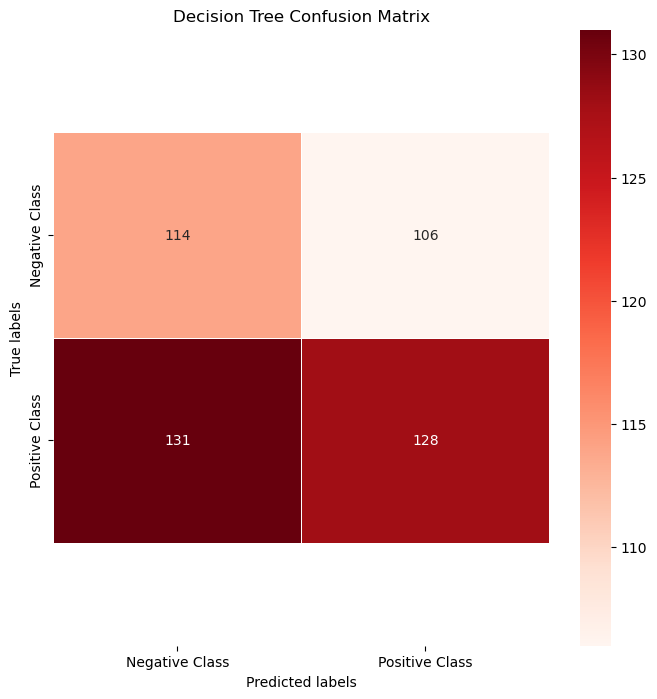

In [95]:
# Generate the confusion matrix
cm_DT = confusion_matrix(y_test, y_pred_DT)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_DT, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Decision Tree Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()

In [96]:
# Print the classification report for the model

# Create and save the training classification report
training_report_DT = classification_report(y_train, DT_training_predictions)
testing_report_DT = classification_report(y_test, y_pred_DT)

# Print the training classification report
print("Decision Tree Classification Report: Training Data")
print("---------------------------------------------------")
print(training_report_DT)
print("")
print("Decision Tree Classification Report: Testing Data")
print("---------------------------------------------------")
print(testing_report_DT)

Decision Tree Classification Report: Training Data
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.49      0.56      0.53       682
           1       0.55      0.48      0.51       753

    accuracy                           0.52      1435
   macro avg       0.52      0.52      0.52      1435
weighted avg       0.52      0.52      0.52      1435


Decision Tree Classification Report: Testing Data
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.52      0.49       220
           1       0.55      0.49      0.52       259

    accuracy                           0.51       479
   macro avg       0.51      0.51      0.50       479
weighted avg       0.51      0.51      0.51       479



### 9. Bagging Decision Tree

In [98]:
base_classifier = DecisionTreeClassifier(random_state=42)
bagging_classifier = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)
bagging_classifier.fit(X_train_scaled, y_train)
BDT_training_predictions = bagging_classifier.predict(X_train_scaled)
y_pred_BDT = bagging_classifier.predict(X_test_scaled)
Accuracy_BDT = accuracy_score(y_test, y_pred_DT)

print(f"Accuracy: {Accuracy_BDT}")

Accuracy: 0.5052192066805845


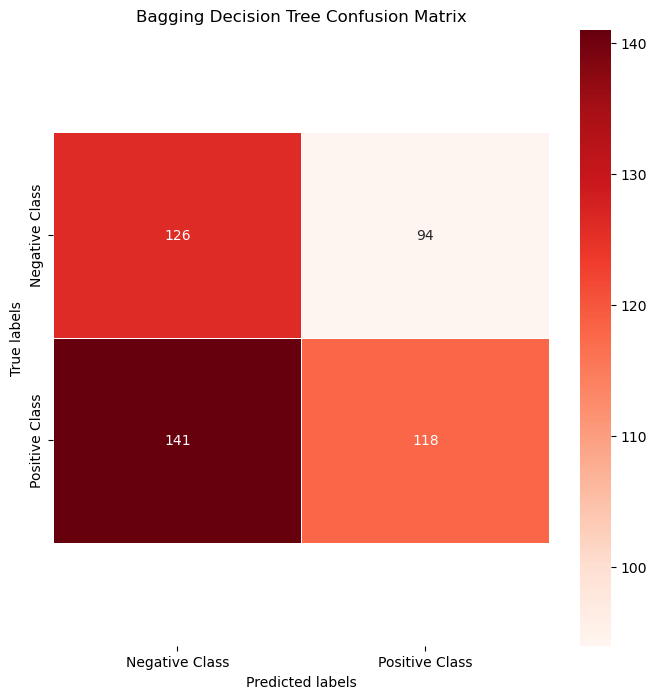

In [123]:
# Generate the confusion matrix
cm_BDT = confusion_matrix(y_test, y_pred_BDT)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_BDT, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Bagging Decision Tree Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()

In [100]:
# Print the classification report for the model

# Create and save the training classification report
training_report_BDT = classification_report(y_train, BDT_training_predictions)
testing_report_BDT = classification_report(y_test, y_pred_BDT)

# Print the training classification report
print("Bagging Decision Tree Classification Report: Training Data")
print("---------------------------------------------------")
print(training_report_BDT)
print("")
print("Bagging Decision Tree Classification Report: Testing Data")
print("---------------------------------------------------")
print(testing_report_BDT)

Bagging Decision Tree Classification Report: Training Data
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       682
           1       1.00      0.98      0.99       753

    accuracy                           0.99      1435
   macro avg       0.99      0.99      0.99      1435
weighted avg       0.99      0.99      0.99      1435


Bagging Decision Tree Classification Report: Testing Data
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.57      0.52       220
           1       0.56      0.46      0.50       259

    accuracy                           0.51       479
   macro avg       0.51      0.51      0.51       479
weighted avg       0.52      0.51      0.51       479



### 10. Gradient Boosting Classifier

In [101]:
GBT_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
GBT_model.fit(X_train_scaled, y_train)
GBT_training_predictions = GBT_model.predict(X_train_scaled)
y_pred_GBT = GBT_model.predict(X_test_scaled)
Accuracy_GBT = accuracy_score(y_test, y_pred_GBT)
print(f"Accuracy: {Accuracy_GBT}")

Accuracy: 0.5156576200417536


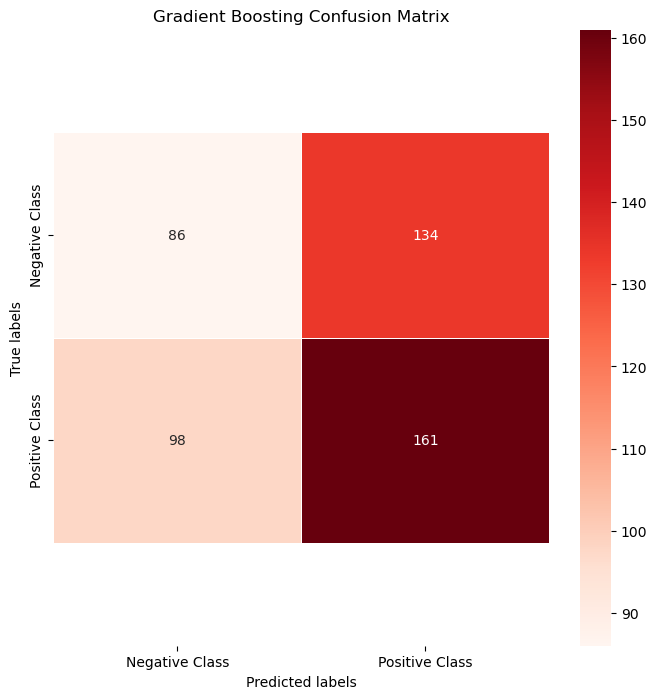

In [124]:
# Generate the confusion matrix
cm_GBT = confusion_matrix(y_test, y_pred_GBT)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_GBT, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Gradient Boosting Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()

In [103]:
# Print the classification report for the model

# Create and save the training classification report
training_report_GBT = classification_report(y_train, DT_training_predictions)
testing_report_GBT = classification_report(y_test, y_pred_DT)

# Print the training classification report
print("Gradient Boosting Classification Report: Training Data")
print("-------------------------------------------------------")
print(training_report_GBT)
print("")
print("Gradient Boosting Classification Report: Testing Data")
print("-------------------------------------------------------")
print(testing_report_GBT)

Gradient Boosting Classification Report: Training Data
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.49      0.56      0.53       682
           1       0.55      0.48      0.51       753

    accuracy                           0.52      1435
   macro avg       0.52      0.52      0.52      1435
weighted avg       0.52      0.52      0.52      1435


Gradient Boosting Classification Report: Testing Data
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.52      0.49       220
           1       0.55      0.49      0.52       259

    accuracy                           0.51       479
   macro avg       0.51      0.51      0.50       479
weighted avg       0.51      0.51      0.51       479



### 11. Support Vector Machine (SVM) 

In [104]:
svm_classifier = SVC(kernel='rbf',C=1.0, gamma='scale')
svm_classifier.fit(X_train_scaled, y_train)

SVM_training_predictions = svm_classifier.predict(X_train_scaled)

y_pred_SVM = svm_classifier.predict(X_test_scaled)

Accuracy_SVM = svm_classifier.score(X_test_scaled, y_test)

print(f"Accuracy: {Accuracy_SVM:.2f}")

Accuracy: 0.53


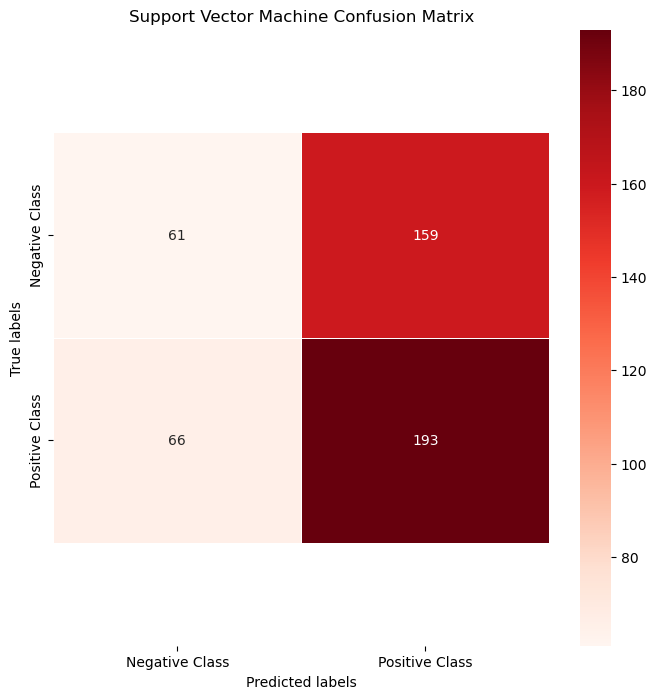

In [125]:
# Generate the confusion matrix
cm_SVM = confusion_matrix(y_test, y_pred_SVM)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_SVM, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Support Vector Machine Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()

In [106]:
# Print the classification report for the model

# Create and save the training classification report
training_report_SVM = classification_report(y_train, SVM_training_predictions)
testing_report_SVM = classification_report(y_test, y_pred_SVM)

# Print the training classification report
print("Support Vector Machine Classification Report: Training Data")
print("-------------------------------------------------------------")
print(training_report_SVM)
print("")
print("Support Vector Machine Classification Report: Testing Data")
print("-------------------------------------------------------------")
print(testing_report_SVM)

Support Vector Machine Classification Report: Training Data
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.38      0.48       682
           1       0.60      0.83      0.69       753

    accuracy                           0.62      1435
   macro avg       0.63      0.60      0.59      1435
weighted avg       0.63      0.62      0.59      1435


Support Vector Machine Classification Report: Testing Data
-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.28      0.35       220
           1       0.55      0.75      0.63       259

    accuracy                           0.53       479
   macro avg       0.51      0.51      0.49       479
weighted avg       0.52      0.53      0.50       479



### 12. Naive Bayes Classifier

In [107]:
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train_scaled, y_train)
NB_training_predictions = naive_bayes_classifier.predict(X_train_scaled)
y_pred_NB = naive_bayes_classifier.predict(X_test_scaled)
Accuracy_NB = accuracy_score(y_test, y_pred_NB)

print(f"Accuracy: {Accuracy_NB}")

Accuracy: 0.46346555323590816


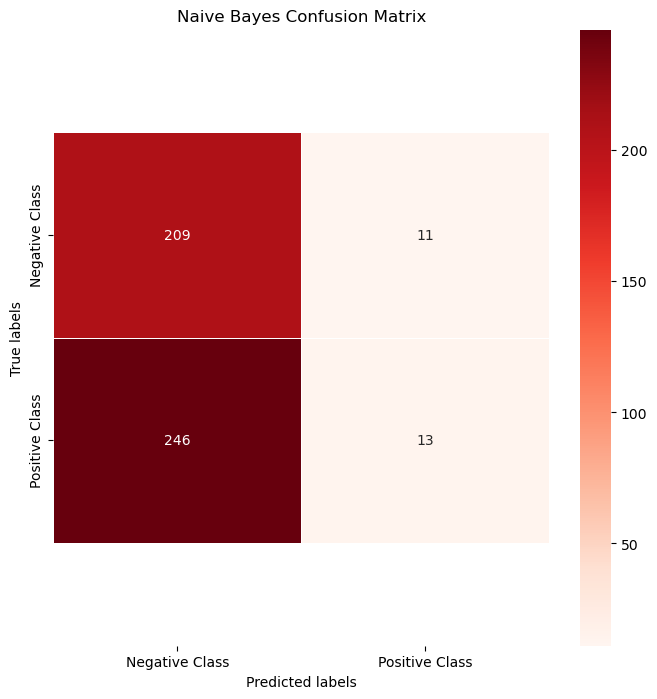

In [126]:
# Generate the confusion matrix
cm_NB = confusion_matrix(y_test, y_pred_NB)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cm_NB, annot=True, ax=ax, fmt="d", linewidths=.5, linecolor='white', cmap="Reds")

# labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Naive Bayes Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative Class', 'Positive Class'])
ax.yaxis.set_ticklabels(['Negative Class', 'Positive Class'])

# Correct the bug from the heatmap function
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values

plt.show()

In [109]:
# Print the classification report for the model

# Create and save the training classification report
training_report_NB = classification_report(y_train, NB_training_predictions)
testing_report_NB = classification_report(y_test, y_pred_NB)

# Print the training classification report
print("Naive Bayes Classification Report: Training Data")
print("---------------------------------------------------")
print(training_report_NB)
print("")
print("Naive Bayes Classification Report: Testing Data")
print("---------------------------------------------------")
print(testing_report_NB)

Naive Bayes Classification Report: Training Data
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.49      0.97      0.65       682
           1       0.73      0.08      0.14       753

    accuracy                           0.50      1435
   macro avg       0.61      0.52      0.39      1435
weighted avg       0.61      0.50      0.38      1435


Naive Bayes Classification Report: Testing Data
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.95      0.62       220
           1       0.54      0.05      0.09       259

    accuracy                           0.46       479
   macro avg       0.50      0.50      0.36       479
weighted avg       0.50      0.46      0.33       479



## Comparing our Accuracy Scores

In [132]:
accuracy_list = [Accuracy_RF, accuracy_XGB, Accuracy_TF2, 
                 Accuracy_LR, Accuracy_LDA, Accuracy_MLP,
                 Accuracy_DT, Accuracy_BDT, 
                 Accuracy_GBT, Accuracy_SVM, Accuracy_NB, Accuracy_KNN]

model_list = ['Random Forest', 'XGBoost', 'Tensor Flow','Logistic Regression', 
              'Linear Discriminat','Neural Network',
              'Decision Tree', 'Bagging Decision Tree', 'Gradient Boosting',
              'Support Vector Machine', 'Naive Bayes', 'KNN']
             

df_accuracy = pd.DataFrame({'Model': model_list, 'Accuracy': accuracy_list})

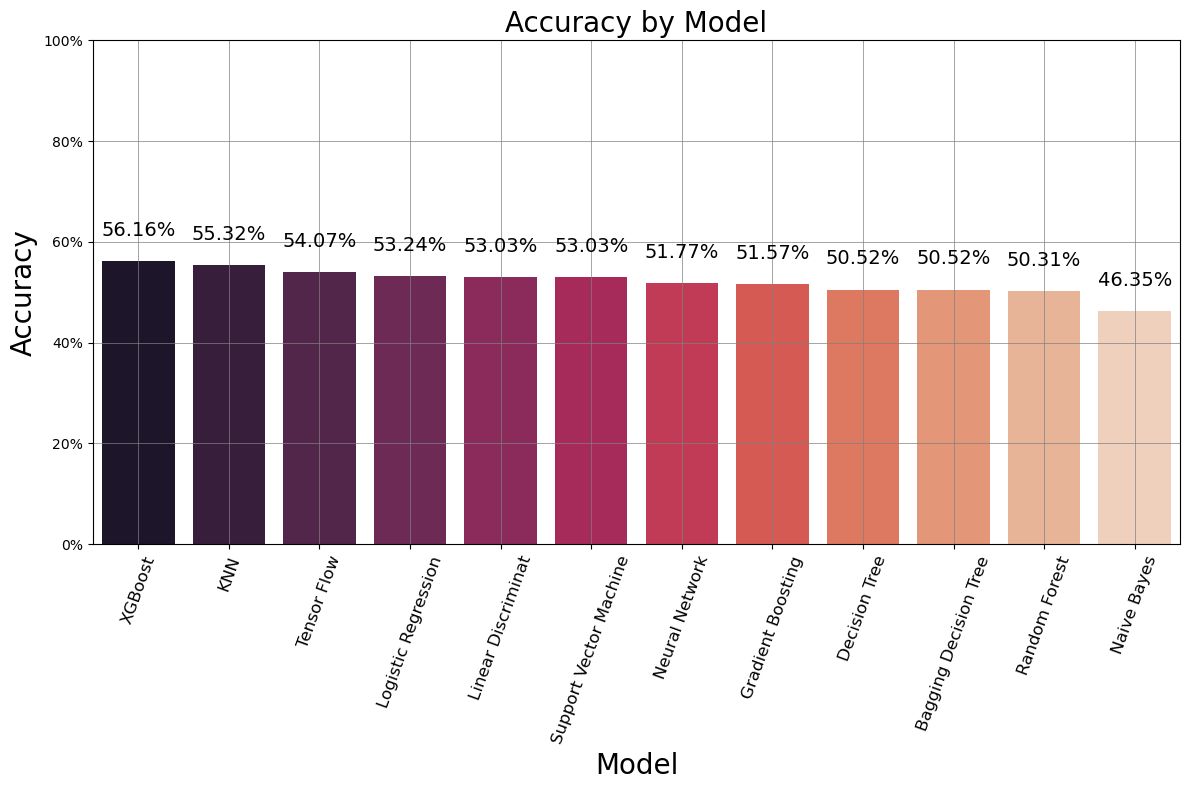

In [133]:
order = list(df_accuracy.sort_values('Accuracy', ascending=False).Model)
df_accuracy = df_accuracy.sort_values('Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

plt.figure(figsize=(12,8))

# Make a barplot and sort bars
x = sns.barplot(x='Model', y="Accuracy", data=df_accuracy, order = order, palette="rocket")
plt.xlabel("Model", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy by Model", fontsize=20)
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.xticks(rotation=70, fontsize=12)
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

for i in range(len(model_list)):
    plt.text(x = i, y = df_accuracy.loc[i, 'Accuracy'] + 0.05, s = str(round((df_accuracy.loc[i, 'Accuracy'])*100, 2))+'%', 
             fontsize = 14, color='black',horizontalalignment='center')

#y_value=['{:,.2f}'.format(x) + '%' for x in ax.get_yticks()]
#ax.set_yticklabels(y_value)

plt.tight_layout()